<a href="https://colab.research.google.com/github/ananyagupta-31/RECOMMENDATION_SYSTEM/blob/main/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task_4 :-Recommendation System

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip


--2025-07-17 11:55:37--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  21.4MB/s    in 0.2s    

2025-07-17 11:55:37 (21.4 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse.linalg import svds
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load ratings

In [ ]:
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

# Load movie titles

In [ ]:
items = pd.read_csv("ml-100k/u.item", sep="|", encoding="latin-1", header=None)
items = items[[0, 1]]
items.columns = ['item_id', 'title']

# Merge for readability

In [ ]:
ratings = ratings.merge(items, on='item_id')

In [ ]:
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Normalize matrix (centered mean)

In [ ]:
user_ratings_mean = np.mean(user_item_matrix.values, axis=1)
R_demeaned = user_item_matrix.values - user_ratings_mean.reshape(-1, 1)

In [ ]:
U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)

# Predicted ratings

In [ ]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
pred_df = pd.DataFrame(predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)

In [ ]:
def recommend_movies(pred_df, user_id, original_ratings, movies_df, num_recommendations=5):
    user_row = pred_df.loc[user_id]
    sorted_user_preds = user_row.sort_values(ascending=False)
    user_data = original_ratings[original_ratings.user_id == user_id]
    watched = user_data.merge(movies_df, on='item_id')

    recommendations = movies_df[~movies_df['item_id'].isin(user_data['item_id'])]
    recommendations = recommendations.merge(pd.DataFrame(sorted_user_preds).reset_index(), on='item_id')
    recommendations.columns = ['item_id', 'title', 'predicted_rating']
    return recommendations.sort_values('predicted_rating', ascending=False).head(num_recommendations)


In [ ]:
recommend_movies(pred_df, 150, ratings, items, 5)

,item_id,title,predicted_rating
5,7,Twelve Monkeys (1995),2.212136
110,117,"Rock, The (1996)",1.742481
476,508,"People vs. Larry Flynt, The (1996)",1.741076
7,9,Dead Man Walking (1995),1.622531
11,15,Mr. Holland's Opus (1995),1.491218


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings, test_size=0.2, random_state=42)

train_matrix = train.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
test_matrix = test.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

train_mean = train_matrix.values.mean(axis=1)
R_demeaned = train_matrix.values - train_mean.reshape(-1, 1)

U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma), Vt) + train_mean.reshape(-1, 1)

# Evaluation

In [ ]:
pred_flat = predicted_ratings[test_matrix.values.nonzero()]
actual_flat = test_matrix.values[test_matrix.values.nonzero()]
rmse = np.sqrt(mean_squared_error(actual_flat, pred_flat))
print(f"RMSE on test set: {rmse:.3f}")

RMSE on test set: 3.429


# Visualization of Top Rated Movies

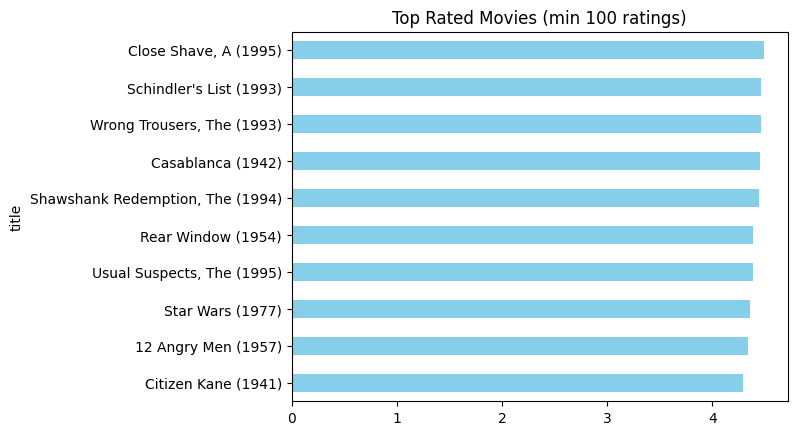

In [ ]:
top_movies = ratings.groupby('title').agg({'rating': ['mean', 'count']})
top_movies.columns = ['avg_rating', 'rating_count']
top_movies = top_movies[top_movies['rating_count'] > 100].sort_values('avg_rating', ascending=False).head(10)

top_movies['avg_rating'].plot(kind='barh', title='Top Rated Movies (min 100 ratings)', color='skyblue')
plt.gca().invert_yaxis()
plt.show()